# UKAN 2023 Hackathon

## Marine Mammal Challenge

### 11-12th September 2023

This notebook shows you how to access the Marine Mammal data
Here we set up the necessary imports for this notebook as well as 4 functions to process the Marine Mammal data in different ways.

In [1]:
%matplotlib inline

In [1]:
import scipy.fft
import scipy.io
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import time
import urllib.request
import math
import pyproj
import pandas as pd
import urllib
import re
import datetime as dt

from nptdms import TdmsFile
import h5py

from skimage.measure import block_reduce

from scipy.signal import butter, lfilter

def applyCosineTaper(Data,TaperLength=20):

    numberOfSamples = Data.shape[-1]
    taper           = np.sin(0.5*np.pi*np.arange(0,TaperLength)/(TaperLength-1))

    window     = np.ones(numberOfSamples)
    window[0:TaperLength] = taper
    window[-TaperLength:] = taper[::-1]

    return Data*window

def butter_bandpass(lowcut, highcut, fs, order=5):
    
    if lowcut <= 0:
        return butter(order, highcut, fs=fs, btype='low', analog=False)
    else:
        return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def ApplyFkFilter(Data,                   \
                  VMin=1200,              \
                  VMax=2200,              \
                  FMin=10,                \
                  FMax=80,                \
                  Taper=(20,20),          \
                  SamplingFrequency=200.0,\
                  Spacing=2.0,            \
                  Smoothing=(50,10),      \
                  Debug    = False):

    small   = 1e-10
    
    data    = np.copy(Data)
    
    data    = applyCosineTaper(data  ,TaperLength=Taper[1])
    data    = applyCosineTaper(data.T,TaperLength=Taper[0]).T

    fk      = scipy.fft.fftshift(scipy.fft.fft2(data))
    fValues = scipy.fft.fftshift(scipy.fft.fftfreq(fk.shape[1],1/SamplingFrequency))
    kValues = scipy.fft.fftshift(scipy.fft.fftfreq(fk.shape[0],Spacing))
    
    kValues[kValues == 0] = np.min(kValues[kValues != 0])
    vMask = np.abs(np.outer(1/kValues,fValues))
    vMask[np.isnan(vMask)] = np.max(vMask) 

    if VMin is None:
        
        vMask[:,:] = 1

    else:

        vMask[ vMask <= VMin ] = small

        if VMax is None:
        
            vMask[ vMask >  VMin ] = 1.0

        else:

            vMask[ vMask >  VMax ] = 1.0        
        
    if FMin is not None:

        vMask[:,np.abs(fValues) < FMin  ] = small

    if FMax is not None:

        vMask[:,np.abs(fValues) > FMax  ] = small

    vMask = scipy.ndimage.gaussian_filter(vMask,sigma=Smoothing)

    Filtered = fk * vMask

    if Debug:
        
        plt.figure(figsize=(15,3))
        plt.subplot(1,3,1)
        vMax=np.percentile(np.log10(np.abs(fk)),99.9)
        f=plt.imshow(np.log10(np.abs(fk)).T,aspect='auto',vmax=vMax,vmin=vMax*0.75,
                   extent=[kValues[0],kValues[-1],fValues[0],fValues[-1]])
        
        plt.plot( kValues,kValues*1500,'k-')
        plt.plot(-kValues,kValues*1500,'k-')

        if VMin is not None:
            plt.plot( kValues,kValues*VMin,'k-',alpha=0.5)
            plt.plot(-kValues,kValues*VMin,'k-',alpha=0.5)
            
        if VMax is not None:
            plt.plot( kValues,kValues*VMax,'k-',alpha=0.5)
            plt.plot(-kValues,kValues*VMax,'k-',alpha=0.5)
            
        plt.ylim(0,0.5*SamplingFrequency)
        plt.xlim(-0.1,0.1)

        plt.subplot(1,3,2)
        f = plt.imshow(np.abs(vMask.T),aspect='auto',
                   extent=[kValues[0],kValues[-1],fValues[0],fValues[-1]])
        
        plt.plot( kValues,kValues*1500,'k-')
        plt.plot(-kValues,kValues*1500,'k-')
        
        if VMin is not None:
            plt.plot( kValues,kValues*VMin,'k-',alpha=0.5)
            plt.plot(-kValues,kValues*VMin,'k-',alpha=0.5)
            
        if VMax is not None:
            plt.plot( kValues,kValues*VMax,'k-',alpha=0.5)
            plt.plot(-kValues,kValues*VMax,'k-',alpha=0.5)
            
        plt.ylim(0,0.5*SamplingFrequency)

        plt.subplot(1,3,3)
        vMax=np.percentile(np.log10(np.abs(Filtered)),99.9)
        f=plt.imshow(np.log10(np.abs(Filtered)).T,aspect='auto',vmax=vMax,vmin=vMax*0.75,
                   extent=[kValues[0],kValues[-1],fValues[0],fValues[-1]])
        
        plt.plot( kValues,kValues*1500,'k-')
        plt.plot(-kValues,kValues*1500,'k-')
        
        if VMin is not None:
            plt.plot( kValues,kValues*VMin,'k-',alpha=0.5)
            plt.plot(-kValues,kValues*VMin,'k-',alpha=0.5)
            
        if VMax is not None:
            plt.plot( kValues,kValues*VMax,'k-',alpha=0.5)
            plt.plot(-kValues,kValues*VMax,'k-',alpha=0.5)

        plt.ylim(-0,0.5*SamplingFrequency)
        plt.xlim(-0.1,0.1)

        plt.show()
        
    Filtered = scipy.fft.ifft2(scipy.fft.ifftshift(Filtered)).real

    if Debug:
        
        plt.figure(figsize=(15,3))
        
        plt.subplot(1,2,1)
        vMax=np.percentile(data,99)
        plt.imshow(data,aspect='auto',cmap='bwr',vmax=vMax,vmin=-vMax)
        #plt.xlim(300,500)
        #plt.ylim(2000,4096)
        
        plt.subplot(1,2,2)
        vMax=np.percentile(Filtered,95)
        plt.imshow(Filtered,aspect='auto',cmap='bwr',vmax=vMax,vmin=-vMax)
        #plt.xlim(300,500)
        #plt.ylim(2000,4096)
        plt.show()

    return Filtered


## Set up Some Useful Variables 
Here we load in the Marine Mammal data in the matlab format and take out useful information so that we can process it.
We then take this data and find a highlighted section which features a whale call, this is then displayed in the graph below.
In this example, we set it up so you can loop through each file and plot the data, however we stop it at the first file so we don't fill the notebook - it can also take a long time to go through each file.

Number of mat Files:  25


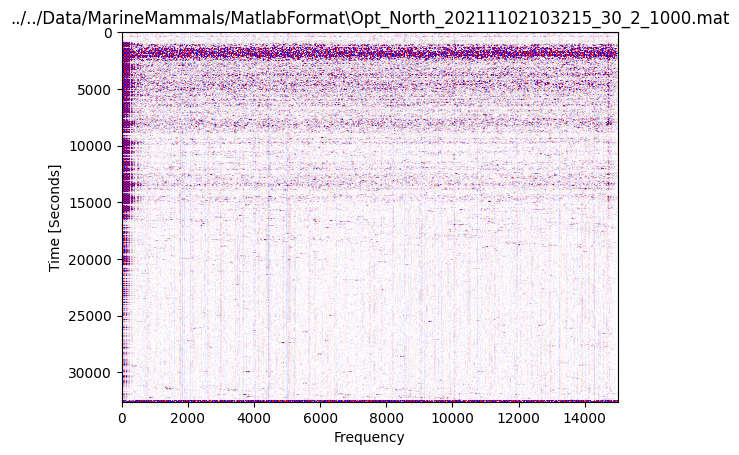

In [3]:
dataDir = r'../../Data/MarineMammals/MatlabFormat/'
files   = sorted(glob.glob(dataDir+'*.mat'))

print('Number of mat Files: ',len(files))

for file in files[0:1]:
    
    data = scipy.io.loadmat(file)['data']
    numberOfChannels,\
    numberOfSamples = data.shape

    samplingFrequency = float(file[0:-4].split("_")[-1])
    gaugeLength       = float(file[0:-4].split("_")[-2])
    channelSpacing    = float(file[0:-4].split("_")[-3])
    
    timeStamp         = file[file.rfind("_2021")+1:file.rfind("_2021")+15]
    dateTime          = dt.datetime.strptime(timeStamp, '%Y%m%d%H%M%S')
    
    mean1 = np.mean(data,axis=1)

    bdata = butter_bandpass_filter(applyCosineTaper((data.T - mean1).T,400),\
                                   10, 30, fs=samplingFrequency, order=5)
    
    vMax = np.percentile(bdata[::,::],90)
    plt.imshow(bdata[::,::],aspect='auto',cmap='bwr',vmin=-vMax,vmax=vMax)
    plt.title(file)
    plt.xlabel('Frequency')
    plt.ylabel('Time [Seconds]')
    plt.show()
    

# Blue Whale example
In this example we take just one of the files to carry and plot through the rest of the notebook.
When we plot all of the data we can clearly see some sort of event part way down the image, which we know to be a Blue Whale call.

Number of mat Files:  1


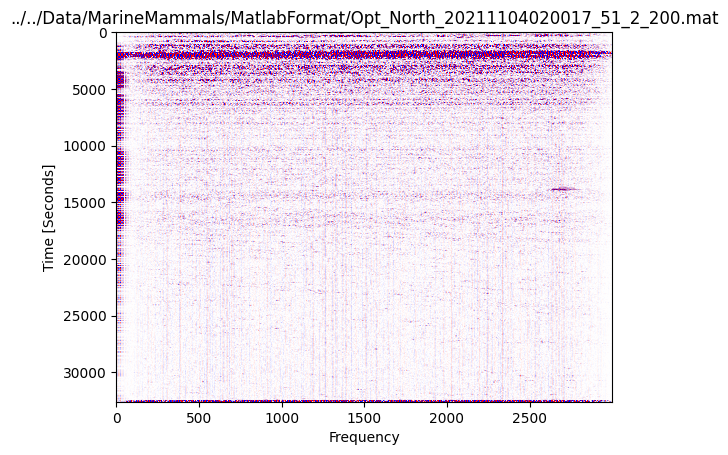

In [4]:
dataDir = r'../../Data/MarineMammals/MatlabFormat/'
files   = sorted(glob.glob(dataDir+'Opt_North_20211104020017_51_2_200.mat'))

print('Number of mat Files: ',len(files))

for file in files:
    
    data = scipy.io.loadmat(file)['data']
    numberOfChannels,\
    numberOfSamples = data.shape

    samplingFrequency = float(file[0:-4].split("_")[-1])
    gaugeLength       = float(file[0:-4].split("_")[-2])
    channelSpacing    = float(file[0:-4].split("_")[-3])
    
    timeStamp         = file[file.rfind("_2021")+1:file.rfind("_2021")+15]
    dateTime          = dt.datetime.strptime(timeStamp, '%Y%m%d%H%M%S')
    
    mean1 = np.mean(data,axis=1)

    bdata = butter_bandpass_filter(applyCosineTaper((data.T - mean1).T,400),\
                                   10, 30, fs=samplingFrequency, order=5)
    
    vMax = np.percentile(bdata[::,::],90)
    plt.imshow(bdata[::,::],aspect='auto',cmap='bwr',vmin=-vMax,vmax=vMax)
    plt.title(file)
    plt.xlabel('Frequency')
    plt.ylabel('Time [Seconds]')
    plt.show()
    

# Blue Whale zoomed in
So that we get a better look at the Blue Whale call, we zoom in to a particular point in the original plot to get a closer look at the Marine Mammal event.

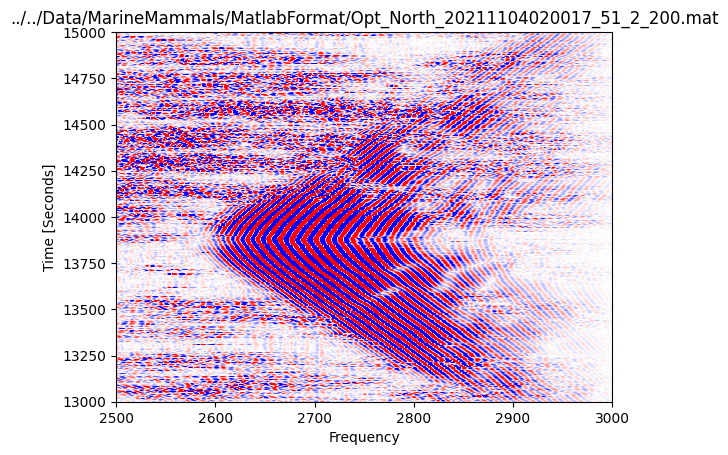

In [5]:
plt.imshow(bdata[::,::],aspect='auto',cmap='bwr',vmin=-vMax,vmax=vMax)
plt.title(file)
plt.xlabel('Frequency')
plt.ylabel('Time [Seconds]')
plt.xlim(2500,3000)
plt.ylim(13000,15000)
plt.show()

# Fin Whale example
In this example, fin whale noises are not as easily seen when viewed zoomed out so we plot the whole set of data, and then use a zoomed in section to highlight this.

Number of mat Files:  1


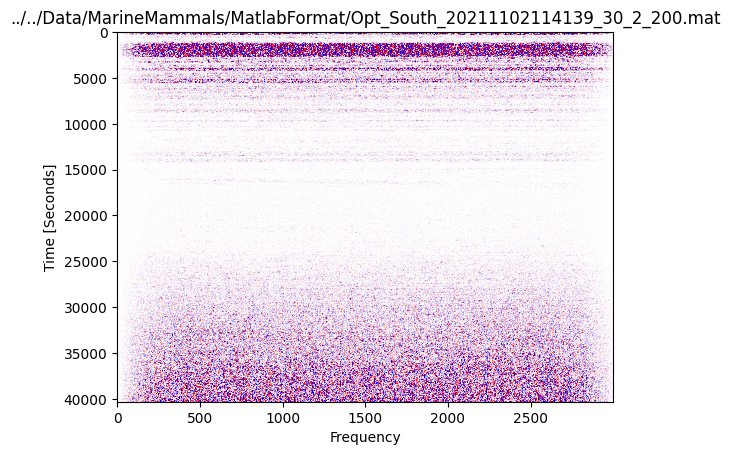

In [6]:
dataDir = r'../../Data/MarineMammals/MatlabFormat/'
files   = sorted(glob.glob(dataDir+'Opt_South_20211102114139_30_2_200.mat'))

print('Number of mat Files: ',len(files))

for file in files[0:1]:
    
    data = scipy.io.loadmat(file)['data']
    numberOfChannels,\
    numberOfSamples = data.shape

    samplingFrequency = float(file[0:-4].split("_")[-1])
    gaugeLength       = float(file[0:-4].split("_")[-2])
    channelSpacing    = float(file[0:-4].split("_")[-3])
    
    timeStamp         = file[file.rfind("_2021")+1:file.rfind("_2021")+15]
    dateTime          = dt.datetime.strptime(timeStamp, '%Y%m%d%H%M%S')
    
    mean1 = np.mean(data,axis=1)

    bdata = butter_bandpass_filter(applyCosineTaper((data.T - mean1).T,400),\
                                   10, 30, fs=samplingFrequency, order=5)
    
    vMax = np.percentile(bdata[::,::],90)
    plt.imshow(bdata[::,::],aspect='auto',cmap='bwr',vmin=-vMax,vmax=vMax)
    plt.title(file)
    plt.xlabel('Frequency')
    plt.ylabel('Time [Seconds]')
    plt.show()
    

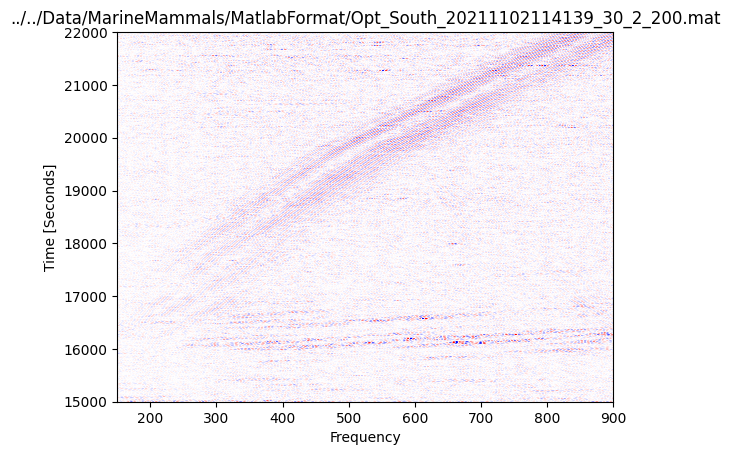

In [7]:
    plt.imshow(bdata[::,::],aspect='auto',cmap='bwr',vmin=-vMax,vmax=vMax)
    plt.title(file)
    plt.xlabel('Frequency')
    plt.ylabel('Time [Seconds]')
    plt.xlim(150,900)
    plt.ylim(15000,22000)
    plt.show()
